In [3]:
import sys
from pathlib import Path
import pandas as pd 
import numpy as np
from scipy.stats import pearsonr


sys.path.append(str(Path("../../..").resolve()))

from src.constants import model_data_dir

In [27]:
df_train = pd.read_csv(model_data_dir / "train_regression.csv").drop(["sc_1d_fwd_rel_ret", "mom_1d_fwd_rel_ret"], axis=1)

dates = df_train.pop("Date")

## Explore ACF

In [20]:
auto_cor = [{"lag": lag, "corr": df_train["value_1d_fwd_rel_ret"].autocorr(lag)} for lag in range(1, 90)]
pd.DataFrame(auto_cor).sort_values("corr", ascending=False).head()

,lag,corr
19,20,0.056040
21,22,0.053327
12,13,0.051467
2,3,0.051342
15,16,0.046260


In [21]:
def cross_corr(df, target, col, lag):
    if col not in ["Date", "value_1d_fwd_rel_ret"]:
        try:
            return pearsonr(df[target][lag:], df[col].shift(lag)[lag:])[0]
        except:
            return np.nan
    
    return np.nan
            
def cross_corrs(df = df_train, target = "value_1d_fwd_rel_ret", lag = 1):
    corr_dict= {}
    for col in df.columns.tolist():
        corr_dict[col] = cross_corr(df, target, col, lag)
    return corr_dict

In [22]:
corrs = pd.DataFrame([cross_corrs(df_train, "value_1d_fwd_rel_ret", lag) 
                            for lag in range(1, 91)])
corrs

,S&P 500,MSCI DM,MSCI EM,WTI Crude Oil,S&P GSCI,Gold,Global Inflation-linked debt,iTraxx Europe 5Yr,iTraxx Crossover 5Yr,CDX IG 5Yr,...,S&P 500 Price-to-Earnings,P/B,US Value P/E over Growth P/E,US Value P/B over Growth P/B,EquityBond premia,S&P 500 Skew,EURUSD Risk Reversal,USDJPY Risk Reversal,EURJPY Risk Reversal,value_1d_fwd_rel_ret
0,-0.001791,0.024310,-0.004278,-0.003564,0.005690,-0.018223,-0.005951,0.006179,0.001021,0.005995,...,0.005728,0.005679,0.003017,0.005503,0.005561,-0.040502,-0.004104,-0.009697,0.000897,NaN
1,-0.020198,0.019017,0.009857,0.001017,-0.007211,-0.008284,0.003618,-0.007063,-0.001935,-0.007194,...,0.022484,0.022466,0.019919,0.022585,0.022479,-0.026264,-0.016397,-0.004264,0.014030,NaN
2,-0.009689,0.010042,0.015068,0.000847,0.006877,0.018172,-0.007597,0.007140,-0.000293,0.006599,...,-0.008170,-0.008223,-0.011089,-0.008381,-0.008265,-0.015992,-0.018073,-0.003642,-0.030575,NaN
3,-0.000812,-0.011267,-0.014605,-0.005491,-0.008177,-0.004890,-0.005658,-0.008125,-0.004944,-0.008395,...,-0.006747,-0.006765,-0.009657,-0.006816,-0.006716,-0.016657,-0.010078,0.000204,-0.000292,NaN
4,0.004874,0.006435,-0.006823,-0.010997,0.010687,0.011904,0.025231,0.010067,0.007309,0.010664,...,0.008955,0.008916,0.006236,0.008824,0.008927,0.000521,-0.048197,-0.005692,-0.014004,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,-0.004647,-0.002569,-0.027556,-0.004514,-0.005817,0.002651,-0.025014,-0.004740,-0.004519,-0.005500,...,0.015954,0.015944,0.016717,0.016164,0.016029,-0.000897,0.030290,0.013904,-0.003656,NaN
86,-0.012092,-0.012238,-0.007414,0.016826,0.014546,-0.017240,-0.049609,0.014727,0.014682,0.014665,...,-0.027443,-0.027436,-0.028592,-0.027694,-0.027381,0.016388,-0.004395,0.005486,0.021592,NaN
87,-0.011883,-0.005793,-0.014724,-0.009587,0.001131,-0.011566,0.008321,0.001146,0.000933,0.000771,...,-0.025433,-0.025474,-0.022546,-0.025131,-0.025903,-0.030148,-0.039038,-0.000113,0.002442,NaN
88,0.003572,-0.017706,0.020161,0.013607,-0.000458,0.018754,0.041315,-0.000668,-0.000785,-0.000498,...,0.009061,0.009139,0.007811,0.009257,0.009025,0.001896,0.019790,-0.003099,0.002479,NaN


## Feature selection

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import RidgeCV

y_train, x_train = df_train.pop("value_1d_fwd_rel_ret"), df_train

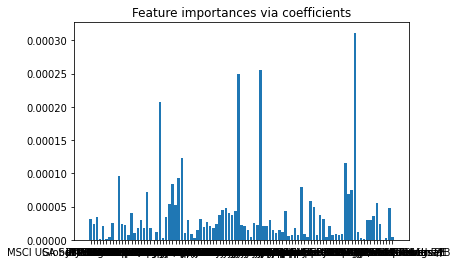

In [31]:
ridge_fit = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(x_train, y_train)
importance = np.abs(ridge_fit.coef_)
feature_names = np.array(x_train.columns)
plt.bar(height=importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.show()

### Sequential selection

In [41]:
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
sfs_forward = SequentialFeatureSelector(
    ridge_fit, n_features_to_select=15, direction="forward"
).fit(x_train, y_train)

In [42]:
feature_names[sfs_forward.get_support()]

array(['WTI Crude Oil', 'S&P GSCI', 'CDX HY 5Yr', 'High Yield Spread',
       'EUR', 'IWF', 'GBP/USD Carry', 'MOVE', 'Gold Vol', 'HY Vol',
       'JPM EM FX Vol', 'US 2Yr swap spread ', 'GDP Libor',
       'Fed Target Rate', 'USDJPY Risk Reversal'], dtype=object)

### Feature selection based on importance

In [48]:
sfm = SelectFromModel(ridge_fit, threshold=np.sort(importance)[-15]).fit(x_train, y_train)
feature_names[sfm.get_support()]

array(['CDX IG 5Yr', 'US HY over IG CDS spread', 'JPY', 'IWF',
       'MSCI USA High Dividend Yield Index',
       'MSCI USA Sector Neutral Quality Index                                                  ',
       'US Recession Probability in 1 year', 'HY Vol',
       'GTCAD10YR Corp                                                  ',
       'GTGBP3MO Corp                                                   ',
       'USD Libor', 'EUR Libor', 'GDP Libor', 'Fed Target Rate',
       'US Value P/B over Growth P/B'], dtype=object)

## Prophet

In [52]:
from fbprophet import Prophet
selected_vars = feature_names[sfs_forward.get_support()]
m = Prophet( weekly_seasonality=True, yearly_seasonality=True)
for var in selected_vars:
    m.add_regressor(var)

In [56]:
df_train["Date"] = dates
df_train["value_1d_fwd_rel_ret"] = y_train
df_model = df_train.rename(columns={"Date": "ds", "value_1d_fwd_rel_ret": "y"})

In [58]:
m.fit(df_model)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/qiushi/workspace/dsi-courses/APlusBernstein-Project/venv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -41.4682


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5481.36    0.00018788        86.531      0.3652           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       5481.45   0.000174125       64.3674   2.077e-06       0.001      179  LS failed, Hessian reset 
     199       5481.47   2.20819e-06       51.7944           1           1      283   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       5481.47   1.22893e-05        88.597   1.635e-07       0.001      361  LS failed, Hessian reset 
     251       5481.48   2.79234e-07       73.4419      0.9556      0.9556      390   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [83]:
df_test = pd.read_csv(model_data_dir / "test_regression.csv")[["Date", "value_1d_fwd_rel_ret"] + selected_vars.tolist()].rename({"Date": "ds"}, axis=1)


/Users/qiushi/workspace/dsi-courses/APlusBernstein-Project/venv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/qiushi/workspace/dsi-courses/APlusBernstein-Project/venv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


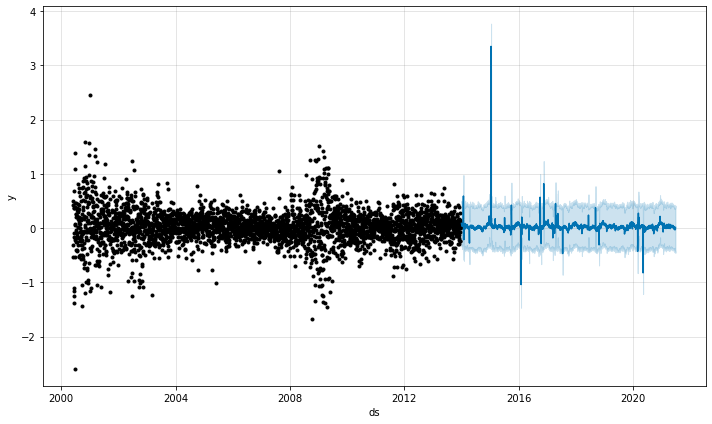

In [84]:
forecast = m.predict(df_test)
fig1 = m.plot(forecast)

<AxesSubplot:xlabel='ds', ylabel='price'>

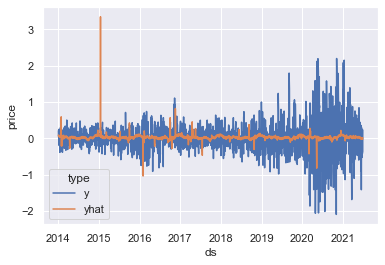

In [99]:
import seaborn as sns
sns.set_theme(style="darkgrid")

plot_data = forecast.assign(y = df_test["value_1d_fwd_rel_ret"])[["ds", "y", "yhat"]].melt(id_vars="ds", var_name="type", value_name="price")

# Plot the responses for different events and regions
sns.lineplot(x="ds", y="price",
             hue="type",
             data=plot_data)

,ds,y,yhat
0,2014-01-02,0.209056,0.086970
1,2014-01-03,0.052192,0.069452
2,2014-01-06,0.009265,0.076076
3,2014-01-07,0.214052,0.078249
4,2014-01-08,0.248013,0.073888
...,...,...,...
1881,2021-06-23,0.220503,-0.014085
1882,2021-06-24,0.126721,-0.023191
1883,2021-06-25,-0.424986,-0.028338
1884,2021-06-28,-0.360834,-0.023700


/Users/qiushi/workspace/dsi-courses/APlusBernstein-Project/venv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/qiushi/workspace/dsi-courses/APlusBernstein-Project/venv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


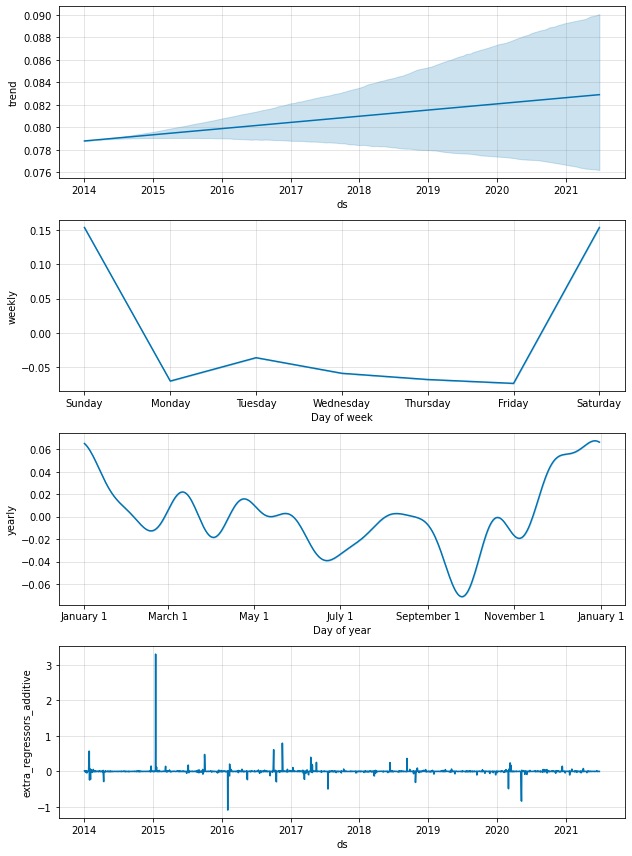

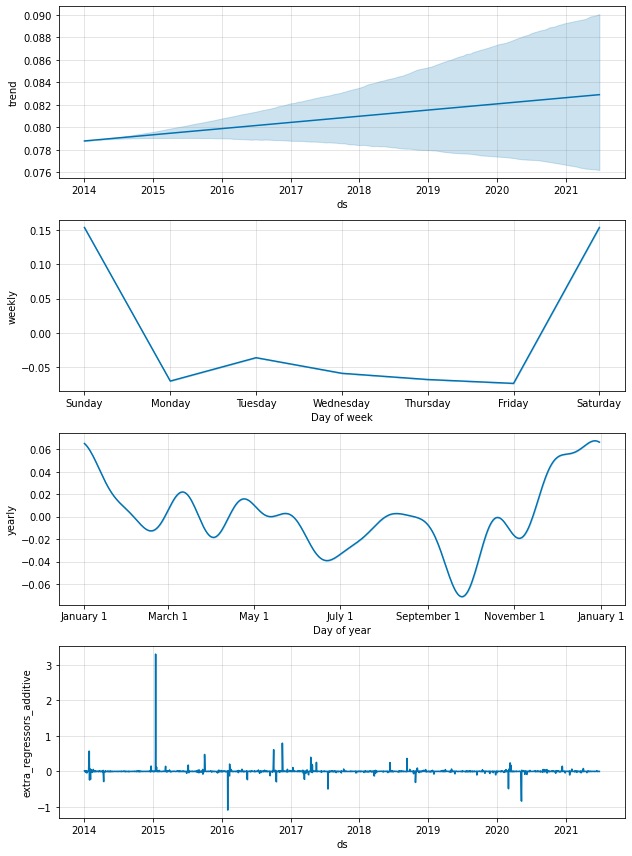

In [78]:
m.plot_components(forecast)